The GPU version of this notebook is
[here](https://drive.google.com/file/d/15lXt6m5Z1yVKjtwFFkBoU05maiktb_mo/view?usp=sharing).

In [1]:
from __future__ import annotations
import time
from typing import Generator

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import Dataset

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline

In [2]:
# assert torch.cuda.is_available(), "This experiment should be run on a GPU"

In [3]:
def time_func(func, *args, num_replications: int = 1, **kwargs) -> list[float]:
    """
    Returns a list, `times`, where `times[i]` is the time it took to run
    `func(*args, **kwargs)` at replication `i` of `num_replications`.
    """
    times = []
    for _ in range(num_replications):
        time_start = time.time()
        _ = func(*args, **kwargs)
        time_end = time.time()
        times.append(time_end - time_start)
    return times


def plot_batch_size_vs_rate(
    batch_size_to_times: dict[int, list[float]],
    application_name: str = "",
) -> tuple[float, float]:
    # flatten dict into arrays
    batch_sizes = np.array(
        [
            batch_size
            for batch_size, processing_times in batch_size_to_times.items()
            for _ in range(len(processing_times))
        ]
    )
    times = np.array(
        [
            processing_time
            for processing_times in batch_size_to_times.values()
            for processing_time in processing_times
        ]
    )
    processing_rates = batch_sizes / times

    # estimate slope and intercept under linear model (_lin) and log-linear model (_log)
    x_lin = batch_sizes[:, None]
    x_log = np.log(x_lin)
    model_lin: LinearRegression = LinearRegression(positive=True).fit(
        X=x_lin, y=processing_rates
    )
    model_log: LinearRegression = LinearRegression(positive=True).fit(
        X=x_log, y=processing_rates
    )
    slope_lin = model_lin.coef_[0]
    slope_log = model_log.coef_[0]
    intercept_lin = model_lin.intercept_
    intercept_log = model_log.intercept_

    # plot
    def equation_repr(slope: float, intercept: float, func_str: str) -> str:
        return (
            f"$\hat{{r}}(n) = {round(slope, 2)} {func_str} n$ "
            f"{'+' if intercept >= 0 else '-'} {round(abs(intercept), 2)}"
        )

    equation_lin = equation_repr(slope_lin, intercept_lin, func_str="")
    equation_log = equation_repr(slope_log, intercept_log, func_str="\ln")
    plt.scatter(batch_sizes, processing_rates, label="observations")
    plt.plot(
        batch_sizes,
        model_lin.predict(x_lin),
        label=equation_lin,
        color="orange",
    )
    plt.plot(
        batch_sizes,
        model_log.predict(x_log),
        label=equation_log,
        color="green",
    )
    plt.xlabel("batch size")
    plt.ylabel("# inputs processed per sec.")
    plt.legend()
    plt.grid()
    plt.ylim(0)
    if application_name:
        plt.title(application_name)

    return slope_lin, intercept_lin, slope_log, intercept_log

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
gpt2_name = "gpt2"  # smallest in the GPT-2 line
gpt2 = AutoModelForCausalLM.from_pretrained(gpt2_name).to(DEVICE)

tokenizer = AutoTokenizer.from_pretrained(gpt2_name)
tokenizer.pad_token_id = tokenizer.eos_token_id  # allow padding -> allow batching

# Input parameters

In [6]:
max_batch_size = 25  # max batch size that you can afford
avg_text_length = 20  # avg length of input text (Poisson distr)
max_new_tokens = 1  # max number tokens to generate
num_replications = 3  # number of replications per batch size

In [7]:
BATCH_SIZES = list(range(1, max_batch_size + 1))

# Time generation

In [8]:
class TextDataset(Dataset):
    def __init__(self, texts: list[str]):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index: int):
        return self.texts[index]

In [9]:
generator = pipeline(
    "text-generation", model=gpt2_name, max_new_tokens=max_new_tokens, device=DEVICE
)
generator.tokenizer.padding_side = "left"  # for sampling
generator.tokenizer.pad_token_id = generator.model.config.eos_token_id

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


One note: these models pad, so there's an extra penalty for waiting. Assume token lengths are Poisson distributed. I've seen this in many many text datasets.

As far as the text itself, I've seen that I can get away w/ just inputting `'aaaaa...'` lol. I still get a tiny bit of variance in the number of generated tokens. And even if I don't, it's ok b/c there's enough variance in the number of tokens to consider the fitted curve realistic.

In [10]:
def generate(texts: list[str], batch_size: int = None):
    batch_size = batch_size or len(texts)
    dataset = TextDataset(texts)
    for _ in generator(
        dataset,
        ## suppress "Setting pad_token_id..." stdout
        pad_token_id=generator.tokenizer.eos_token_id,
        batch_size=batch_size,
    ):
        pass  ## we don't need the output for anything

In [11]:
# warm up model just in case
generate(["go, bwah"])

In [12]:
batch_size_to_times = dict()

for i, batch_size in tqdm(
    enumerate(BATCH_SIZES), total=len(BATCH_SIZES), desc="Batch size loop"
):
    rng = np.random.default_rng(i + abs(hash("am bored")))
    lengths = 1 + rng.poisson(
        lam=avg_text_length - 1, size=batch_size * num_replications
    )
    texts = ["a" * length for length in lengths]
    times = time_func(
        generate,
        texts,
        num_replications=num_replications,
        batch_size=batch_size,
    )
    batch_size_to_times[batch_size] = times

Batch size loop:   0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
application_name = "GPT-2 text generation ($\mathbf{C}$PU)"

(0.21509935661116983,
 3.830255063601899,
 2.1302865443527583,
 1.6839747103285152)

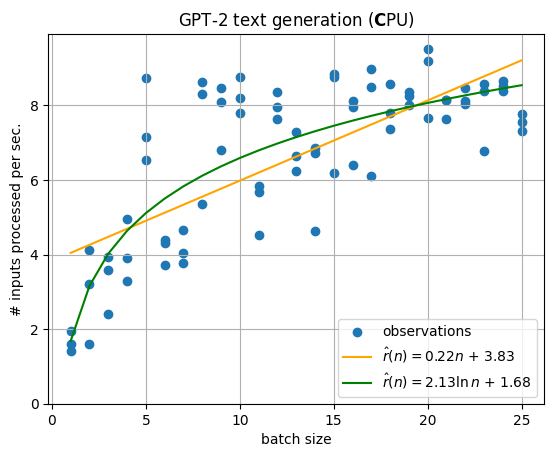

In [14]:
plot_batch_size_vs_rate(batch_size_to_times, application_name=application_name)

# Simulate solution

This simulation needs to be ran on GPU but we'll test the code runs on CPU.

### Utilities

In [15]:
def _requests_stream(
    requests: list, inter_request_times: list[float], seed: int = None
):
    if len(requests) != len(inter_request_times):
        raise ValueError("requests and inter_request_times have different lengths")

    def stream():
        for request, inter_request_time in zip(requests, inter_request_times):
            time.sleep(inter_request_time)
            yield request

    return stream

In [16]:
def batch_requests(
    stream: Generator, batch_size: int, max_delay_sec: float
) -> Generator:
    """
    Converts a stream of single inputs into a stream of batched inputs by waiting in
    between inputs.

    Parameters
    ----------
    stream : Generator
        Stream of single inputs
    batch_size : int
        Maximum number of inputs in each batch.
    max_delay_sec : float
        Maximum time to wait before generating a batch. If the time since receiving the
        first input in the batch exceeds `max_delay_sec`, then the batch is generated
        despite having fewer than `batch_size` inputs. Set this to ``math.inf`` to
        guarantee that every generated batch has size `batch_size`.

    Yields
    ------
    list
        batched inputs.
    """
    batch = []
    start_time = time.time()

    for obj in stream:
        batch.append(obj)
        time_since_first_obj_in_batch_received = time.time() - start_time

        if (
            len(batch) == batch_size
            or time_since_first_obj_in_batch_received >= max_delay_sec
        ):
            yield batch
            batch = []
            start_time = time.time()

    # there are ungenerated objects from the last batch if neither condition was met
    if batch:
        yield batch

In [17]:
def time_per_batch(
    func,
    requests: list,
    inter_request_times: list[float],
    batch_size: int,
    seed: int = None,
    **func_kwargs
) -> list[float]:
    stream = _requests_stream(requests, inter_request_times, seed)
    times = []
    num_batches = int(np.ceil(len(requests) / batch_size))
    for batch in tqdm(
        batch_requests(stream(), batch_size, max_delay_sec=np.inf),
        total=num_batches,
        desc=f"batch size = {batch_size}",
    ):
        time = time_func(func, batch, num_replications=1, **func_kwargs)
        times.append(time[0])  # just 1 replication
    return times

In [18]:
def latencies(
    inter_request_times: list[float], time_per_batch: list[float]
) -> np.ndarray:
    num_batches = len(time_per_batch)
    request_arrival_times = np.cumsum(inter_request_times)
    request_arrival_times_per_batch = np.array(
        np.split(request_arrival_times, num_batches)
    )
    finish_times_per_batch = request_arrival_times_per_batch[:, -1] + np.array(time_per_batch)
    latencies: np.ndarray = (
        finish_times_per_batch[:, np.newaxis] - request_arrival_times_per_batch
    )
    return latencies.flatten()

### Dataset

In [19]:
batch_size_opt = 9
avg_inter_request_time_sec = 0.01
num_batches = 20

num_requests = batch_size_opt * num_batches
# num_requests is a multiple of the batch size we're testing against. this makes later
# calculations easier

rng = np.random.default_rng(abs(hash("overkill")))
lengths = 1 + rng.poisson(lam=avg_text_length - 1, size=num_requests)
texts = ["a" * length for length in lengths]

rng = np.random.default_rng(abs(hash("hola")))
inter_request_times = rng.exponential(
    scale=avg_inter_request_time_sec, size=num_requests
)

### Simulation results

In [20]:
time_per_batch_size_1 = time_per_batch(
    generate, texts, inter_request_times, batch_size=1, seed=123
)

batch size = 1:   0%|          | 0/180 [00:00<?, ?it/s]

In [21]:
time_per_batch_size_opt = time_per_batch(
    generate, texts, inter_request_times, batch_size=batch_size_opt, seed=123
)

batch size = 9:   0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
latencies_batch_size_1 = latencies(inter_request_times, time_per_batch_size_1)

In [23]:
latencies_batch_size_opt = latencies(inter_request_times, time_per_batch_size_opt)

In [24]:
latencies_batch_size_opt.mean()

0.4581167304537874

In [25]:
latencies_batch_size_1.mean()

0.12540479633543228

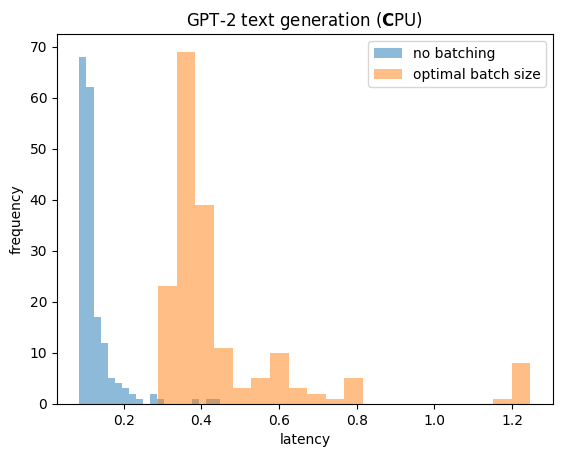

In [26]:
plt.hist(latencies_batch_size_1, label="no batching", bins=20, alpha=0.5)
plt.hist(latencies_batch_size_opt, label="optimal batch size", bins=20, alpha=0.5)
plt.legend()
plt.xlabel("latency")
plt.ylabel("frequency")
plt.title(application_name);